In [1]:
# Installing necessary libraries

!pip install cellpylib

In [2]:
# Importing necessary libraries

import cellpylib as cpl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch import Tensor
import seaborn as sns
import time
import math
import matplotlib.cm as cm # For colourmap plots later
from tqdm import tqdm

In [3]:
# Optional. Makes the outputs more readable by surpressing certain warnings.

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
# Parameters

# Data generation parameters
data_size = 100 # the number of data points in each row of data
timesteps = 100 # the number of timesteps which each programme is run for before the output is used to train the model

# Model parameters
num_epochs = 2000  # Number of training epochs #Later move to 1000 epochs
hidden_size = 512  # Update with the desired size of the hidden layer
learning_rate = 0.005 # learning rate used later in the optimizer
batch_size = 128 # Batch size used when creating the train and test datasets. 32 is more suitable for this problem. 
epochs = np.arange(0,num_epochs, 1) # Used in plotting
accuracy_frequency = 10 # Used in the evaluation of the model #Later move to 1. moving_avg will clear up plots

In [5]:
# Define the programme probability distribution, weighting highly autocorrelated programmes more heavily.

def prog_dist_antiweight_autocorr(): # Takes the autocorrelations of programmes, and makes less 
    # autocorrelated programmes more common
    #autocorr = [100, 61.84, 64.8, 62.4, 100, 63.63, 100, 50.3, 52.27, 50.24, 50.2, 48.16, 100, 100]
    #programmes = [0, 10, 20, 63, 64, 95, 96, 110, 125, 195, 204, 225, 249, 255] # a fairly random selection. All unique
    autocorr = [100, 61.84, 64.8, 62.4, 100, 63.63, 100, 50.3, 52.27, 50.24, 50.2, 48.16]
    programmes = [0, 10, 20, 63, 64, 95, 96, 110, 125, 195, 204, 225]
    prog_list = np.zeros(256)
    for index, item in enumerate(programmes):
        autocorrelation = autocorr[index]
        prog_list[item] = (autocorrelation + 1)**(-1)
    prog_list_norm = [x / sum(prog_list) for x in prog_list]
    return prog_list_norm

def prog_dist_weight_autocorr(): #Make more autocorrelated programmes more common
    #autocorr = [100, 61.84, 64.8, 62.4, 100, 63.63, 100, 50.3, 52.27, 50.24, 50.2, 48.16, 100, 100]
    #programmes = [0, 10, 20, 63, 64, 95, 96, 110, 125, 195, 204, 225, 249, 255] # a fairly random selection. All unique
    autocorr = [100, 61.84, 64.8, 62.4, 100, 63.63, 100, 50.3, 52.27, 50.24, 50.2, 48.16]
    programmes = [0, 10, 20, 63, 64, 95, 96, 110, 125, 195, 204, 225]
    prog_list = np.zeros(256)
    for index, item in enumerate(programmes):
        autocorrelation = autocorr[index]
        prog_list[item] = (100 - autocorrelation + 1)**(-1)
    prog_list_norm = [x / sum(prog_list) for x in prog_list]
    return prog_list_norm

programmes_prob_distribution = prog_dist_antiweight_autocorr() #changing this to antiweight makes it negatively corr

In [6]:
# Model Initialisation / Training setup

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.bn2 = nn.BatchNorm1d(num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.bn2(out)
        return out

# Define the input size, hidden size, and number of classes
input_size = data_size  # Update with the actual input size
num_classes = 256 #Number of potential classes, here stuck at 256
#num_classes = 12

# Create an instance of the neural network
model = NeuralNetwork(input_size, hidden_size, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [7]:
# Define a way to reset weights

def reset_weights(model):
    for module in model.modules():
        if isinstance(module, nn.Linear):
            module.reset_parameters()

In [8]:
# Data generation functions (where the programmes_considered have a probability distribution)

def create_data(data_size, programmes_prob_distribution, number_of_samples, timesteps):

    # Creating the dataset and labels variables to be populated later
    dataset = np.empty(shape=(number_of_samples, data_size), dtype=int) # each row is data_size length, with number_of_samples rows
    labels = np.empty(shape=(1, number_of_samples), dtype=int)

    # Stating the space of considered programmes
    programmes = np.arange(0,256,1)

    # Normalising the distribution in case it is not already normalised
    programmes_total = sum(programmes_prob_distribution)
    programmes_prob_distribution_norm = [x / programmes_total for x in programmes_prob_distribution]
    
    for i in range(number_of_samples):

        # Randomly selecting a rule number according to the probability distribution given
        rule_number = np.random.choice(a = programmes, size=None, replace=True, p = programmes_prob_distribution_norm)
        #print(f"Considering rule_number = ", rule_number)
        cellular_automaton = cpl.init_random(data_size)
        cellular_automaton = cpl.evolve(cellular_automaton, timesteps=timesteps, memoize=True, apply_rule=lambda n, c, t: cpl.nks_rule(n, rule_number))
        #print(cellular_automaton[-1])
        dataset[i] = cellular_automaton[-1]
        labels[:,i] = rule_number

    return [dataset, labels]

def data_loader(data_size, programmes_prob_distribution, number_of_samples, timesteps):

    # Generate the data according to input parameters
    [dataset, labels] = create_data(data_size, programmes_prob_distribution, number_of_samples, timesteps)
    labels = labels[0] # Deal with the fact that the output is a list of a single list

    # Shifting the labels such that they are indexed from 0. Required for cross entropy to work
    #labels = [x - min(labels) for x in labels] #!!! Not currently shifting labels in a test to alter them later - may help with training in smaller batches
    # Use data_split
    data = [(data_sample, label) for data_sample, label in zip(dataset, labels)]

    train_dataset, train_labels = zip(*data)
    
    tensor_train_dataset = TensorDataset(Tensor(train_dataset), Tensor(train_labels))
    
    train_loader = DataLoader(tensor_train_dataset, batch_size=batch_size, shuffle=True)

    return train_loader

In [9]:
# Evaluates a model over the space of all possible functions. Outputs a vector giving that performance

def model_evaluation(model, data_size, timesteps, batch_size):

    # State which programmes are being considered. In this case, it's all of them.
    #programmes_considered = np.arange(0,256,1) #NOTE: THIS DISABLING IS TEMPORARY. AIM TO REINTRODUCE IT
    programmes_considered = np.array([0, 10, 20, 63, 64, 95, 96, 110, 125, 195, 204, 225, 249, 255]) # The programmes used at the moment in autocorrelation

    accuracy_vector = np.empty(256)
    
    for programme in programmes_considered:

        programmes_prob_distribution = [0]*256
        programmes_prob_distribution[programme] = 1

        train_loader = data_loader(data_size, programmes_prob_distribution, batch_size, timesteps)

        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for data, labels in train_loader:
                outputs = model(data)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
            accuracy = 100 * correct / total #returns the accuracy as a percentage
            #print(f"For programme " + str(programme) + ": Accuracy = " + str(accuracy))
        accuracy_vector[programme] = accuracy
                
    return accuracy_vector

In [10]:
# Training loop (includes data generation). Note that here training and test loss cease to make much sense

def main_train(data_size, programmes_prob_distribution, batch_size, timesteps, num_epochs):

    # Initisalise training and test loss tracking variables
    training_loss = np.empty(num_epochs)

    # Initialise an array to track not only the general training and test loss, but also the accuracy on individual programme classification during training.
    # This is to attempt to see grokking.
    # Form: Each row of accuracy_array is an epoch, each column of accuracy_array is a binary 1 or 0 based on whether or not it was correctly classified. 
    #accuracy_frequency = 100 # Once every 100 epochs, the accuracy is measured
    accuracy_array = np.empty((math.floor(num_epochs/accuracy_frequency), 256))
    # Initialising variaable for tracking where in the accuracy_array to write data
    eval_count = 0
    # Each epoch here trains over 1 batch size of data (which at the moment is 32). Each epoch is therefore smaller and better controlled.
    for epoch in tqdm(range(num_epochs)):

        # Continually monitoring accuracy of the model by adjusting the accuracy_array
        if epoch%accuracy_frequency==0:
            accuracy_vector = model_evaluation(model, data_size, timesteps, batch_size)
            accuracy_array[eval_count] = accuracy_vector
            eval_count += 1
        
        train_loader = data_loader(data_size, programmes_prob_distribution, batch_size, timesteps)
        for data, labels in train_loader:
            # Forward pass
            outputs = model(data)
    
            #Shifting labels for loss calculation
            shifted_labels = labels - torch.min(labels)
            shifted_labels = shifted_labels.long()
            loss = criterion(outputs, shifted_labels)
                
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Print the loss after each epoch
        if epoch%100==0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")
        training_loss[epoch] = loss.item()

    return [training_loss, accuracy_array]

In [11]:
#[training_loss, accuracy_array] = main_train(data_size, programmes_prob_distribution, batch_size, timesteps, num_epochs)

In [17]:
def accuracy_plot(ax, moving_avg, num_epochs, rel_list, repeat_idx, accuracy_array):
    
    print(f'moving average = ', moving_avg)
    
    epochs = np.arange(1, num_epochs - num_epochs%moving_avg + 1,1)

    rel_array = np.array(rel_list)
    #lines_plotted = uncorr_array[0:3]
    #lines_plotted = rel_array[2: 5]
    uncorr_array = rel_array
    lines_plotted = rel_array

    rel_epochs = [x for x, index in enumerate(epochs) if index%accuracy_frequency==0]

    # Create an axis object for the line plot
    cmap = cm.get_cmap('rainbow')  # You can choose different colormaps

    # Taking values from nearby epochs and averaging
    reshaped_epochs = np.reshape(rel_epochs, (-1, moving_avg))
    filtered_epochs = reshaped_epochs[:,0]
    repeated_filtered_epochs = np.repeat(filtered_epochs, moving_avg)

    for i in tqdm(lines_plotted):
        line = accuracy_array[:,i]
        #color = cmap(lines_plotted[np.where(lines_plotted==i)[0][0]] / (len(lines_plotted) - 1))
        #color = cmap(index / (len(lines_plotted) - 1))
        color = cmap(np.where(lines_plotted == i)[0][0] / (len(lines_plotted) - 1))
        reshaped_line = np.reshape(line, (-1, moving_avg))
        programme_label = 'Programme: ' + str(uncorr_array[np.where(lines_plotted==i)][0])
        pandas_df = pd.DataFrame({programme_label: reshaped_line.flatten(), 'Epochs': repeated_filtered_epochs})
        pandas_df_melted = pd.melt(pandas_df, id_vars = 'Epochs', value_vars = [programme_label], var_name='line', value_name = 'Values')
        #fig, ax = plt.subplots()
        sns.lineplot(data=pandas_df_melted, x='Epochs', y='Values', hue='line', ax=ax, palette = [color], errorbar=None)

    # Create a ScalarMappable object for the colorbar
    norm = plt.Normalize(0, len(lines_plotted) - 1)
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])  # Set an empty array to associate with the colorbar
    cbar = plt.colorbar(sm, ax=ax)

    cbar.set_label('Program Number')

    num_ticks = len(lines_plotted)  # Number of desired ticks
    indices = np.linspace(0, len(lines_plotted) - 1, num_ticks, dtype=int)
    tick_positions = indices
    tick_labels = lines_plotted[indices]

    cbar.set_ticks(tick_positions)
    cbar.set_ticklabels(tick_labels)

    ax.get_legend().remove()

    ax.set_ylabel('Accuracy (%)')

  0%|          | 0/2000 [00:00<?, ?it/s]C:\Users\plogo\AppData\Local\Temp\ipykernel_10132\2903999265.py:42: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\b\abs_6fueooay2f\croot\pytorch-select_1707342446212\work\torch\csrc\utils\tensor_new.cpp:278.)
  tensor_train_dataset = TensorDataset(Tensor(train_dataset), Tensor(train_labels))
  0%|          | 1/2000 [00:30<17:10:54, 30.94s/it]

Epoch [1/2000], Loss: 5.506844997406006


  5%|▌         | 101/2000 [09:24<5:26:50, 10.33s/it]

Epoch [101/2000], Loss: 4.1241607666015625


 10%|█         | 201/2000 [17:47<5:09:13, 10.31s/it]

Epoch [201/2000], Loss: 3.0211172103881836


 15%|█▌        | 301/2000 [26:23<5:02:09, 10.67s/it]

Epoch [301/2000], Loss: 2.697216272354126


 20%|██        | 401/2000 [35:00<6:12:01, 13.96s/it]

Epoch [401/2000], Loss: 2.6308326721191406


 25%|██▌       | 501/2000 [43:33<4:35:03, 11.01s/it]

Epoch [501/2000], Loss: 2.5904014110565186


 30%|███       | 601/2000 [51:30<4:03:10, 10.43s/it]

Epoch [601/2000], Loss: 2.58882474899292


 35%|███▌      | 701/2000 [59:27<3:42:11, 10.26s/it]

Epoch [701/2000], Loss: 2.4416518211364746


 40%|████      | 801/2000 [1:07:17<3:33:26, 10.68s/it]

Epoch [801/2000], Loss: 2.520324468612671


 45%|████▌     | 901/2000 [1:15:05<3:18:19, 10.83s/it]

Epoch [901/2000], Loss: 2.3620243072509766


 50%|█████     | 1001/2000 [1:23:49<3:06:04, 11.18s/it]

Epoch [1001/2000], Loss: 2.4533863067626953


 55%|█████▌    | 1101/2000 [1:31:55<2:31:57, 10.14s/it]

Epoch [1101/2000], Loss: 2.383741617202759


 60%|██████    | 1201/2000 [1:39:55<2:26:32, 11.00s/it]

Epoch [1201/2000], Loss: 2.2736117839813232


 65%|██████▌   | 1301/2000 [1:47:44<2:00:51, 10.37s/it]

Epoch [1301/2000], Loss: 2.2071645259857178


 70%|███████   | 1401/2000 [1:56:27<2:04:51, 12.51s/it]

Epoch [1401/2000], Loss: 2.122016668319702


 75%|███████▌  | 1501/2000 [2:04:54<1:23:32, 10.05s/it]

Epoch [1501/2000], Loss: 2.04213285446167


 80%|████████  | 1601/2000 [2:12:36<1:10:14, 10.56s/it]

Epoch [1601/2000], Loss: 1.9465711116790771


 85%|████████▌ | 1701/2000 [2:21:12<56:02, 11.24s/it]  

Epoch [1701/2000], Loss: 1.984181523323059


 90%|█████████ | 1801/2000 [2:29:11<36:34, 11.03s/it]

Epoch [1801/2000], Loss: 1.8670390844345093


 95%|█████████▌| 1901/2000 [2:36:46<16:55, 10.25s/it]

Epoch [1901/2000], Loss: 1.8257453441619873


100%|██████████| 2000/2000 [2:43:51<00:00,  4.92s/it]
C:\Users\plogo\AppData\Local\Temp\ipykernel_10132\1564914665.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow')  # You can choose different colormaps


moving average =  1


  0%|          | 1/2000 [00:28<16:02:45, 28.90s/it]

Epoch [1/2000], Loss: 5.4773268699646


  5%|▌         | 101/2000 [08:01<5:15:37,  9.97s/it]

Epoch [101/2000], Loss: 3.300323009490967


 10%|█         | 201/2000 [15:35<4:56:53,  9.90s/it]

Epoch [201/2000], Loss: 2.6571691036224365


 15%|█▌        | 301/2000 [23:07<4:46:11, 10.11s/it]

Epoch [301/2000], Loss: 2.5070066452026367


 20%|██        | 401/2000 [30:42<4:23:14,  9.88s/it]

Epoch [401/2000], Loss: 2.3842151165008545


 25%|██▌       | 501/2000 [38:41<4:48:27, 11.55s/it]

Epoch [501/2000], Loss: 2.4485960006713867


 30%|███       | 601/2000 [46:29<4:03:40, 10.45s/it]

Epoch [601/2000], Loss: 2.2702903747558594


 35%|███▌      | 701/2000 [54:51<3:51:17, 10.68s/it]

Epoch [701/2000], Loss: 2.2199556827545166


 40%|████      | 801/2000 [1:02:45<3:25:53, 10.30s/it]

Epoch [801/2000], Loss: 2.1103880405426025


 45%|████▌     | 901/2000 [1:10:58<3:10:56, 10.42s/it]

Epoch [901/2000], Loss: 2.0279362201690674


 50%|█████     | 1001/2000 [1:19:17<2:52:33, 10.36s/it]

Epoch [1001/2000], Loss: 1.9746190309524536


 55%|█████▌    | 1101/2000 [1:26:58<2:19:51,  9.33s/it]

Epoch [1101/2000], Loss: 1.854454517364502


 60%|██████    | 1201/2000 [1:34:16<2:08:19,  9.64s/it]

Epoch [1201/2000], Loss: 1.7924143075942993


 65%|██████▌   | 1301/2000 [1:42:11<1:57:03, 10.05s/it]

Epoch [1301/2000], Loss: 1.7483891248703003


 70%|███████   | 1401/2000 [1:50:02<2:16:25, 13.66s/it]

Epoch [1401/2000], Loss: 1.7208839654922485


 75%|███████▌  | 1501/2000 [1:57:59<1:28:10, 10.60s/it]

Epoch [1501/2000], Loss: 1.6558974981307983


 80%|████████  | 1601/2000 [2:06:03<1:15:36, 11.37s/it]

Epoch [1601/2000], Loss: 1.5953751802444458


 85%|████████▌ | 1701/2000 [2:18:17<1:27:28, 17.55s/it]

Epoch [1701/2000], Loss: 1.6113152503967285


 90%|█████████ | 1801/2000 [3:08:00<33:53, 10.22s/it]    

Epoch [1801/2000], Loss: 1.587143063545227


 95%|█████████▌| 1901/2000 [3:15:39<16:27,  9.98s/it]

Epoch [1901/2000], Loss: 1.5441150665283203


100%|██████████| 2000/2000 [3:22:51<00:00,  6.09s/it]
C:\Users\plogo\AppData\Local\Temp\ipykernel_10132\1564914665.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow')  # You can choose different colormaps


moving average =  1


  0%|          | 1/2000 [00:29<16:17:36, 29.34s/it]

Epoch [1/2000], Loss: 5.341802597045898


  5%|▌         | 101/2000 [08:04<5:24:41, 10.26s/it]

Epoch [101/2000], Loss: 2.750439167022705


 10%|█         | 201/2000 [15:42<5:03:30, 10.12s/it]

Epoch [201/2000], Loss: 2.4400975704193115


 15%|█▌        | 301/2000 [23:16<4:42:58,  9.99s/it]

Epoch [301/2000], Loss: 2.2550747394561768


 20%|██        | 401/2000 [30:56<4:26:59, 10.02s/it]

Epoch [401/2000], Loss: 2.1420421600341797


 25%|██▌       | 501/2000 [38:32<4:18:16, 10.34s/it]

Epoch [501/2000], Loss: 2.038601875305176


 30%|███       | 601/2000 [46:11<3:54:56, 10.08s/it]

Epoch [601/2000], Loss: 1.9227490425109863


 35%|███▌      | 701/2000 [53:45<3:37:36, 10.05s/it]

Epoch [701/2000], Loss: 1.7945530414581299


 40%|████      | 801/2000 [1:01:22<3:19:44, 10.00s/it]

Epoch [801/2000], Loss: 1.8336431980133057


 45%|████▌     | 901/2000 [1:09:00<3:04:39, 10.08s/it]

Epoch [901/2000], Loss: 1.738793969154358


 50%|█████     | 1001/2000 [1:16:37<2:48:07, 10.10s/it]

Epoch [1001/2000], Loss: 1.700977087020874


 55%|█████▌    | 1101/2000 [1:24:12<2:30:08, 10.02s/it]

Epoch [1101/2000], Loss: 1.6092047691345215


 60%|██████    | 1201/2000 [1:31:51<2:12:54,  9.98s/it]

Epoch [1201/2000], Loss: 1.598936676979065


 65%|██████▌   | 1301/2000 [1:39:25<1:56:51, 10.03s/it]

Epoch [1301/2000], Loss: 1.5822309255599976


 70%|███████   | 1401/2000 [1:47:03<1:40:37, 10.08s/it]

Epoch [1401/2000], Loss: 1.583953857421875


 75%|███████▌  | 1501/2000 [1:54:37<1:23:35, 10.05s/it]

Epoch [1501/2000], Loss: 1.578928828239441


 80%|████████  | 1601/2000 [2:02:12<1:06:19,  9.97s/it]

Epoch [1601/2000], Loss: 1.5320415496826172


 85%|████████▌ | 1701/2000 [2:09:47<49:41,  9.97s/it]  

Epoch [1701/2000], Loss: 1.5210728645324707


 90%|█████████ | 1801/2000 [2:17:24<33:07,  9.99s/it]

Epoch [1801/2000], Loss: 1.4747449159622192


 95%|█████████▌| 1901/2000 [2:25:01<16:58, 10.28s/it]

Epoch [1901/2000], Loss: 1.432552695274353


100%|██████████| 2000/2000 [2:32:10<00:00,  4.57s/it]
C:\Users\plogo\AppData\Local\Temp\ipykernel_10132\1564914665.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow')  # You can choose different colormaps


moving average =  1


  0%|          | 1/2000 [00:28<15:49:42, 28.51s/it]

Epoch [1/2000], Loss: 5.312057018280029


  5%|▌         | 101/2000 [08:02<5:28:02, 10.36s/it]

Epoch [101/2000], Loss: 2.600486993789673


 10%|█         | 201/2000 [15:39<5:00:46, 10.03s/it]

Epoch [201/2000], Loss: 2.2580416202545166


 15%|█▌        | 301/2000 [59:58<5:36:44, 11.89s/it]   

Epoch [301/2000], Loss: 2.1085755825042725


 20%|██        | 401/2000 [1:09:06<5:23:06, 12.12s/it]

Epoch [401/2000], Loss: 1.9860650300979614


 25%|██▌       | 501/2000 [1:18:08<4:58:05, 11.93s/it]

Epoch [501/2000], Loss: 1.858296275138855


 30%|███       | 601/2000 [1:27:21<4:41:01, 12.05s/it]

Epoch [601/2000], Loss: 1.7841546535491943


 35%|███▌      | 701/2000 [1:36:18<4:12:37, 11.67s/it]

Epoch [701/2000], Loss: 1.676928162574768


 40%|████      | 801/2000 [1:45:17<3:54:26, 11.73s/it]

Epoch [801/2000], Loss: 1.6707929372787476


 45%|████▌     | 901/2000 [1:54:17<3:54:10, 12.78s/it]

Epoch [901/2000], Loss: 1.6415687799453735


 50%|█████     | 1001/2000 [2:03:19<3:23:54, 12.25s/it]

Epoch [1001/2000], Loss: 1.5611059665679932


 55%|█████▌    | 1101/2000 [2:12:22<3:04:54, 12.34s/it]

Epoch [1101/2000], Loss: 1.5422427654266357


 60%|██████    | 1201/2000 [2:21:23<2:39:08, 11.95s/it]

Epoch [1201/2000], Loss: 1.4937001466751099


 65%|██████▌   | 1301/2000 [2:30:20<2:18:50, 11.92s/it]

Epoch [1301/2000], Loss: 1.4960983991622925


 70%|███████   | 1401/2000 [2:39:15<1:59:04, 11.93s/it]

Epoch [1401/2000], Loss: 1.5004191398620605


 75%|███████▌  | 1501/2000 [2:48:07<1:38:59, 11.90s/it]

Epoch [1501/2000], Loss: 1.45614755153656


 80%|████████  | 1601/2000 [2:57:12<1:18:58, 11.88s/it]

Epoch [1601/2000], Loss: 1.4756255149841309


 85%|████████▌ | 1701/2000 [3:06:01<57:54, 11.62s/it]  

Epoch [1701/2000], Loss: 1.4304418563842773


 90%|█████████ | 1801/2000 [3:14:52<39:03, 11.77s/it]

Epoch [1801/2000], Loss: 1.4406485557556152


 95%|█████████▌| 1901/2000 [3:23:38<19:22, 11.74s/it]

Epoch [1901/2000], Loss: 1.4619860649108887


100%|██████████| 2000/2000 [3:31:47<00:00,  6.35s/it]
C:\Users\plogo\AppData\Local\Temp\ipykernel_10132\1564914665.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow')  # You can choose different colormaps


moving average =  1


100%|██████████| 12/12 [00:00<00:00, 18.21it/s]


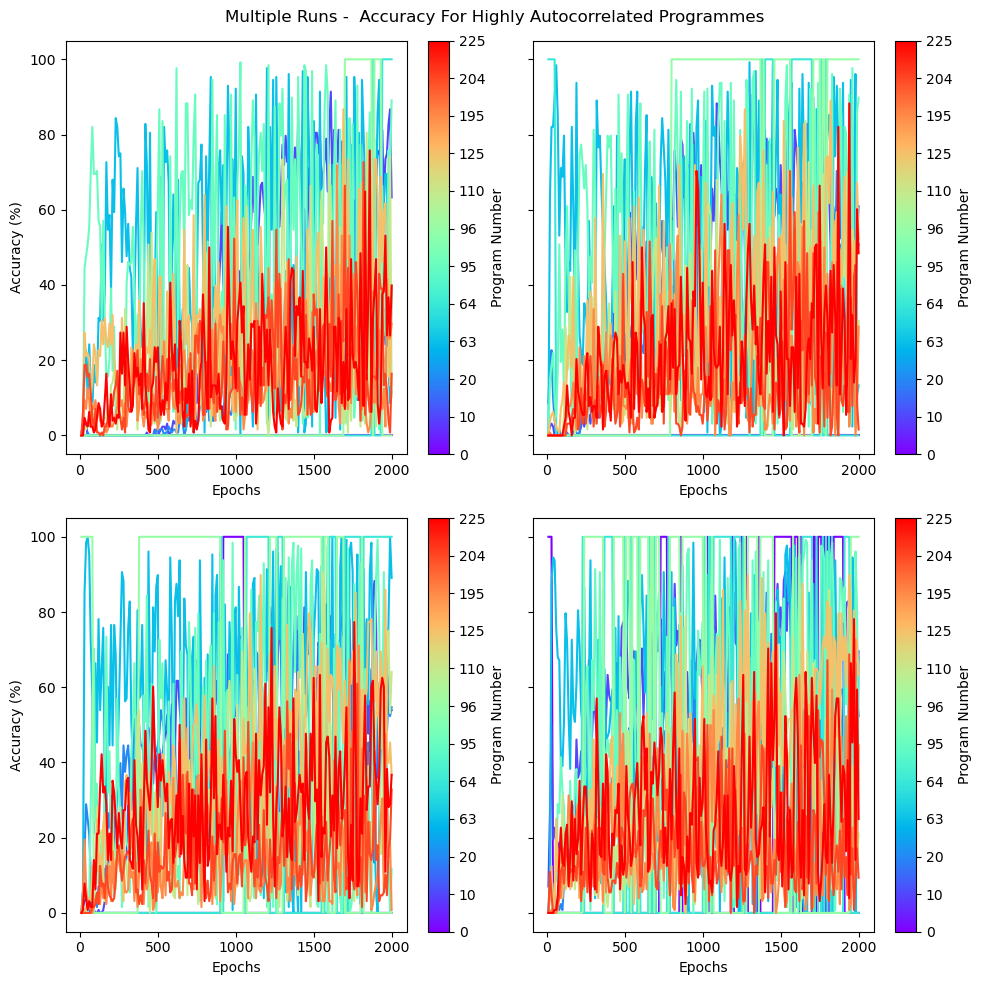

In [13]:
# Creating subplots for different runs    
    
#rel_list = [0, 10, 20, 63, 64, 95, 96, 110, 125, 195, 204, 225, 249, 255]
rel_list = [0, 10, 20, 63, 64, 95, 96, 110, 125, 195, 204, 225]
num_repeats = 4 # Must be even, sorry
moving_avg = 1
fig, axs = plt.subplots(2, int(num_repeats/2), figsize=(5*(int(num_repeats/2)),5*(int(num_repeats/2))), sharey='row')
training_loss_list = []
accuracy_array_list = []
for repeat_idx in range(num_repeats):
    reset_weights(model)
    [training_loss, accuracy_array] = main_train(data_size, programmes_prob_distribution, batch_size, timesteps, num_epochs)
    training_loss_list.append(training_loss)
    accuracy_array_list.append(accuracy_array)
    accuracy_plot(axs[repeat_idx // (num_repeats//2), repeat_idx % (num_repeats//2)], moving_avg, num_epochs, rel_list, repeat_idx, accuracy_array)
    
plt.suptitle('Multiple Runs -  Accuracy For Highly Autocorrelated Programmes')
plt.tight_layout()
plt.show()  

In [14]:
# Pickle the results of the above calculation to avoid unneccesary corruption

import pickle

# Save training_loss_list to a file
with open('training_loss_list_autocorr_negative.pkl', 'wb') as f:
    pickle.dump(training_loss_list, f)
    
# Saving accuracy array
with open('accuracy_array_list_autocorr_negative.pkl', 'wb') as f:
    pickle.dump(accuracy_array_list, f)

If the above code works as expected, and gives desirable results, then it will be repeated almost verbatim for the reversed case of when autocorrelation is negatively weighted (which I expect to give more interpretable results). Note that all of the data from this run is being carefully saved (and should probably be pickled) to allow for easy formatting changes.

In addition, this code should allow for Hierarhical clustering to be run. The larger number of progammes there might present an issue, but I expect it would be fine. Then, runnning the reverse version would give me four plots and potentially a clear case for correlation in learning algorithm design.

C:\Users\plogo\AppData\Local\Temp\ipykernel_10132\389204207.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow')  # You can choose different colormaps


moving average =  10


100%|██████████| 6/6 [00:00<00:00, 26.17it/s]
C:\Users\plogo\AppData\Local\Temp\ipykernel_10132\389204207.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow')  # You can choose different colormaps


moving average =  10


100%|██████████| 6/6 [00:00<00:00, 27.32it/s]
C:\Users\plogo\AppData\Local\Temp\ipykernel_10132\389204207.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow')  # You can choose different colormaps


moving average =  10


100%|██████████| 6/6 [00:00<00:00, 29.42it/s]
C:\Users\plogo\AppData\Local\Temp\ipykernel_10132\389204207.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow')  # You can choose different colormaps


moving average =  10


100%|██████████| 6/6 [00:00<00:00, 27.26it/s]


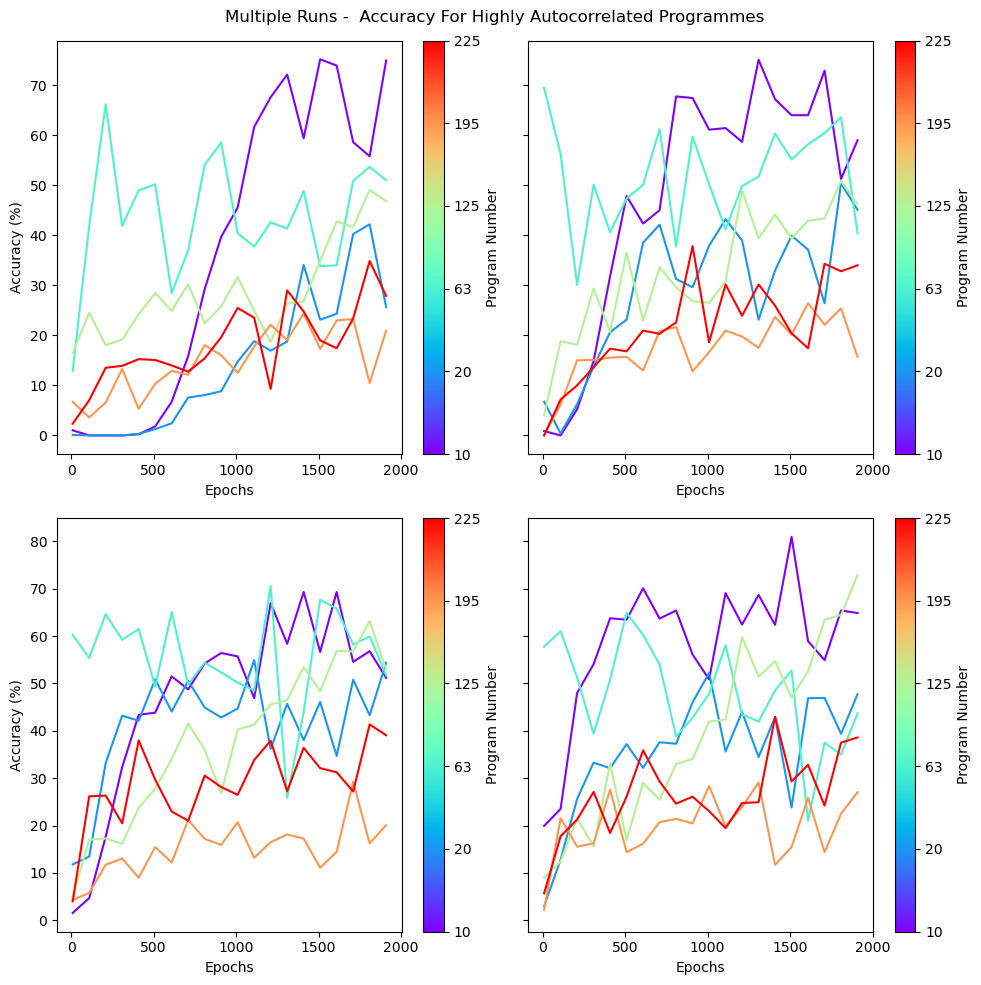

In [24]:
# Repeating the above plot, but with a higher moving average

rel_list = [10, 20, 63, 125, 195, 225]
num_repeats = 4 # Must be even, sorry
moving_avg = 10
fig, axs = plt.subplots(2, int(num_repeats/2), figsize=(5*(int(num_repeats/2)),5*(int(num_repeats/2))), sharey='row')
for repeat_idx in range(num_repeats):
    #reset_weights(model)
    #[training_loss, accuracy_array] = main_train(data_size, programmes_prob_distribution, batch_size, timesteps, num_epochs)
    #training_loss_list.append(training_loss)
    #accuracy_array_list.append(accuracy_array)
    accuracy_array = accuracy_array_list[repeat_idx]
    accuracy_plot(axs[repeat_idx // (num_repeats//2), repeat_idx % (num_repeats//2)], moving_avg, num_epochs, rel_list, repeat_idx, accuracy_array)
    
plt.suptitle('Multiple Runs -  Accuracy For Highly Autocorrelated Programmes')
plt.tight_layout()
plt.show()  